# Importing Required Libraries

In [528]:
import pandas as pd
import numpy as np
import  haversine as hs
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from IPython.display import Image 
from sklearn.tree import export_graphviz
import pydotplus
import graphviz
import os
from io import StringIO
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Importing csv files to Panda's DataFrame

In [529]:
df=pd.read_csv(r'YourCabs_training.csv')
df.head(5)

,id,user_id,vehicle_model_id,package_id,travel_type_id,from_area_id,to_area_id,from_city_id,to_city_id,from_date,to_date,online_booking,mobile_site_booking,booking_created,from_lat,from_long,to_lat,to_long,Car_Cancellation,Cost_of_error
0,132512,22177,28,NaN,2,83.0,448.0,NaN,NaN,01-01-2013 02:00,NaN,0,0,01-01-2013 01:39,12.924150,77.672290,12.927320,77.635750,0,1.0
1,132513,21413,12,NaN,2,1010.0,540.0,NaN,NaN,01-01-2013 09:00,NaN,0,0,01-01-2013 02:25,12.966910,77.749350,12.927680,77.626640,0,1.0
2,132514,22178,12,NaN,2,1301.0,1034.0,NaN,NaN,01-01-2013 03:30,NaN,0,0,01-01-2013 03:08,12.937222,77.626915,13.047926,77.597766,0,1.0
3,132515,13034,12,NaN,2,768.0,398.0,NaN,NaN,01-01-2013 05:45,NaN,0,0,01-01-2013 04:39,12.989990,77.553320,12.971430,77.639140,0,1.0
4,132517,22180,12,NaN,2,1365.0,849.0,NaN,NaN,01-01-2013 09:00,NaN,0,0,01-01-2013 07:53,12.845653,77.677925,12.954340,77.600720,0,1.0


# Dropping the columns not required for analysis

In [530]:
#Dropping as single value has more percentage for vehicle_model_id
df=df.drop(["id","user_id","vehicle_model_id","package_id","from_city_id","to_city_id","to_date","Cost_of_error"],axis=1)
df.head(3)

,travel_type_id,from_area_id,to_area_id,from_date,online_booking,mobile_site_booking,booking_created,from_lat,from_long,to_lat,to_long,Car_Cancellation
0,2,83.0,448.0,01-01-2013 02:00,0,0,01-01-2013 01:39,12.924150,77.672290,12.927320,77.635750,0
1,2,1010.0,540.0,01-01-2013 09:00,0,0,01-01-2013 02:25,12.966910,77.749350,12.927680,77.626640,0
2,2,1301.0,1034.0,01-01-2013 03:30,0,0,01-01-2013 03:08,12.937222,77.626915,13.047926,77.597766,0


# Data Transformation

In [531]:
df["from_area_id"].fillna(int(df["from_area_id"].median()),inplace=True)

In [532]:
df["to_area_id"].fillna(int(df["to_area_id"].median()),inplace=True)

In [533]:
df.isnull().sum()

travel_type_id            0
from_area_id              0
to_area_id                0
from_date                 0
online_booking            0
mobile_site_booking       0
booking_created           0
from_lat                 93
from_long                93
to_lat                 9138
to_long                9138
Car_Cancellation          0
dtype: int64

In [534]:
df['to_lat_temp']=df['to_lat'].fillna(df.groupby('to_area_id')['to_lat'].transform('median'))

In [535]:
df['to_long_temp']=df['to_long'].fillna(df.groupby('to_area_id')['to_long'].transform('median'))

In [536]:
df['from_lat_temp']=df['from_lat'].fillna(df.groupby('from_area_id')['from_lat'].transform('median'))

In [537]:
df['from_long_temp']=df['from_long'].fillna(df.groupby('from_area_id')['from_long'].transform('median'))

In [538]:
df['fromDay'] = pd.DatetimeIndex(df['from_date']).day_name()

In [539]:
df['from_date'] = pd.to_datetime(df['from_date'])

In [540]:
df['fromTiming']=(df['from_date'].dt.hour%24+4)//4     #to use dt we have to change it to datetime field
df['fromTiming'].replace({1: 'Late Night',
                      2: 'Early Morning',
                      3: 'Morning',
                      4: 'Noon',
                      5: 'Evening',
                      6: 'Night'}, inplace=True)

In [541]:
lat1 = 52.2296756
lon1 = 21.0122287
lat2 = 52.406374
lon2 = 16.9251681
coord_1 = (lat1, lon1)
coord_2 = (lat2, lon2)
x = hs.haversine(coord_1,coord_2)
print(f'The distance is {int(x)} km')

The distance is 278 km


In [542]:
df[['from_lat_temp','from_long_temp','to_lat_temp','to_long_temp']].head(5)

,from_lat_temp,from_long_temp,to_lat_temp,to_long_temp
0,12.924150,77.672290,12.927320,77.635750
1,12.966910,77.749350,12.927680,77.626640
2,12.937222,77.626915,13.047926,77.597766
3,12.989990,77.553320,12.971430,77.639140
4,12.845653,77.677925,12.954340,77.600720


In [543]:
for i in df.index:
    lon1 = df["from_lat_temp"].iloc[i]
    lat1 = df["from_long_temp"].iloc[i]
    lon2 = df["to_lat_temp"].iloc[i]
    lat2 = df["to_long_temp"].iloc[i]
    df.loc[i, 'haversine_dist'] = hs.haversine((lon1,lat1),(lon2,lat2))

In [544]:
df['distance']=df.apply(lambda x : hs.haversine((x['from_lat_temp'],x['from_long_temp'])
                            ,(x['to_lat_temp'],x['to_long_temp'])),axis=1)

In [545]:
df.loc[df['Car_Cancellation']==0].groupby('from_area_id')['Car_Cancellation'].count().iloc[1]

7

In [546]:
df['areaIdWiseCancelation']=df.loc[df['Car_Cancellation']==1].groupby('from_area_id')['from_area_id'].transform('count')

In [547]:
df['areaIdWiseTranscations']=df.groupby('from_area_id')['from_area_id'].transform('count')

In [548]:
df.loc[df['Car_Cancellation']==1].groupby('from_area_id')['from_area_id'].transform('count')

21        37
64        33
281       39
361       39
523       11
        ... 
43406     20
43408     20
43411      9
43414      9
43422    116
Name: from_area_id, Length: 3132, dtype: int64

In [549]:
df['areaIdWiseCancelation'].isnull().sum()

40299

In [550]:
df['areaIdWiseCancelation'].replace(np.nan,0,inplace=True) #not canceled transactions are converted to low 

In [551]:
#df['areaIdWiseCancelation%']=round((df['areaIdWiseCancelation']/len(df))*100,2)
df['areaIdWiseCancelation%']=round((df['areaIdWiseCancelation']/df['areaIdWiseTranscations'])*100,2)

In [552]:
df.loc[(df['from_area_id']==1010.0) & (df['Car_Cancellation']==1),'from_area_id'].count()

53

In [553]:
df['areaIdWiseCancelationGD']=df['areaIdWiseCancelation%'].apply(lambda x :'Low' if x < 33.3 
                                                                                 else ('Medium' if x < 66.6  else 'High'))

In [554]:
df['difference']=pd.to_datetime(df['from_date'])-pd.to_datetime(df['booking_created'])

In [555]:
df['differenceMinutes']=df['difference']/np.timedelta64(1,'m')

In [556]:
df.loc[(df['areaIdWiseCancelationGD']=='High')&( df['Car_Cancellation']==1) ].head(5)

,travel_type_id,from_area_id,to_area_id,from_date,online_booking,mobile_site_booking,booking_created,from_lat,from_long,to_lat,...,fromDay,fromTiming,haversine_dist,distance,areaIdWiseCancelation,areaIdWiseTranscations,areaIdWiseCancelation%,areaIdWiseCancelationGD,difference,differenceMinutes
2252,2,130.0,625.0,2013-01-28 06:00:00,1,0,1/25/2013 13:55,12.79665,77.38693,12.95431,...,Monday,Early Morning,33.965108,33.965108,4.0,5,80.00,High,2 days 16:05:00,3845.0
12938,2,130.0,393.0,2013-05-11 04:30:00,0,0,05-10-2013 09:46,12.79665,77.38693,13.19956,...,Saturday,Early Morning,56.646811,56.646811,4.0,5,80.00,High,0 days 18:44:00,1124.0
14433,2,130.0,1247.0,2013-05-21 16:30:00,1,0,5/20/2013 15:42,12.79665,77.38693,12.96691,...,Tuesday,Evening,43.608931,43.608931,4.0,5,80.00,High,1 days 00:48:00,1488.0
15336,2,130.0,353.0,2013-05-26 23:30:00,1,0,5/26/2013 22:25,12.79665,77.38693,13.03241,...,Sunday,Night,34.874567,34.874567,4.0,5,80.00,High,0 days 01:05:00,65.0
15987,2,630.0,1384.0,2013-05-31 22:00:00,1,0,5/31/2013 14:57,12.91220,77.51043,13.02853,...,Friday,Night,13.505101,13.505101,2.0,3,66.67,High,0 days 07:03:00,423.0


# Encoding the data

In [557]:
one_hot_encoded_data=pd.get_dummies(df["travel_type_id"],prefix='travel_tpe')

In [558]:
one_hot_encoded_data

,travel_tpe_1,travel_tpe_2,travel_tpe_3
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0
...,...,...,...
43426,0,1,0
43427,0,1,0
43428,0,0,1
43429,0,1,0


In [559]:
df = pd.merge(
    left=df,
    right=one_hot_encoded_data,
    left_index=True,
    right_index=True)
df.head(3)

,travel_type_id,from_area_id,to_area_id,from_date,online_booking,mobile_site_booking,booking_created,from_lat,from_long,to_lat,...,distance,areaIdWiseCancelation,areaIdWiseTranscations,areaIdWiseCancelation%,areaIdWiseCancelationGD,difference,differenceMinutes,travel_tpe_1,travel_tpe_2,travel_tpe_3
0,2,83.0,448.0,2013-01-01 02:00:00,0,0,01-01-2013 01:39,12.924150,77.672290,12.927320,...,3.975770,0.0,719,0.0,Low,0 days 00:21:00,21.0,0,1,0
1,2,1010.0,540.0,2013-01-01 09:00:00,0,0,01-01-2013 02:25,12.966910,77.749350,12.927680,...,13.995053,0.0,768,0.0,Low,0 days 06:35:00,395.0,0,1,0
2,2,1301.0,1034.0,2013-01-01 03:30:00,0,0,01-01-2013 03:08,12.937222,77.626915,13.047926,...,12.708431,0.0,125,0.0,Low,0 days 00:22:00,22.0,0,1,0


In [573]:
df2=df.drop(['travel_type_id','from_area_id','to_area_id','from_date','areaIdWiseCancelation','areaIdWiseTranscations','areaIdWiseCancelation%','travel_tpe_3',
            'difference','from_lat','from_long','to_lat','to_long','booking_created'],axis=1)

In [574]:
df2.head(3)

,online_booking,mobile_site_booking,Car_Cancellation,to_lat_temp,to_long_temp,from_lat_temp,from_long_temp,fromDay,fromTiming,haversine_dist,distance,areaIdWiseCancelationGD,differenceMinutes,travel_tpe_1,travel_tpe_2
0,0,0,0,12.927320,77.635750,12.924150,77.672290,Tuesday,Late Night,3.975770,3.975770,Low,21.0,0,1
1,0,0,0,12.927680,77.626640,12.966910,77.749350,Tuesday,Morning,13.995053,13.995053,Low,395.0,0,1
2,0,0,0,13.047926,77.597766,12.937222,77.626915,Tuesday,Late Night,12.708431,12.708431,Low,22.0,0,1


In [575]:
num = df2.select_dtypes(include='number')
char = df2.select_dtypes(include='object')

In [576]:
num.head(3)

,online_booking,mobile_site_booking,Car_Cancellation,to_lat_temp,to_long_temp,from_lat_temp,from_long_temp,haversine_dist,distance,differenceMinutes,travel_tpe_1,travel_tpe_2
0,0,0,0,12.927320,77.635750,12.924150,77.672290,3.975770,3.975770,21.0,0,1
1,0,0,0,12.927680,77.626640,12.966910,77.749350,13.995053,13.995053,395.0,0,1
2,0,0,0,13.047926,77.597766,12.937222,77.626915,12.708431,12.708431,22.0,0,1


In [577]:
char.head(3)

,fromDay,fromTiming,areaIdWiseCancelationGD
0,Tuesday,Late Night,Low
1,Tuesday,Morning,Low
2,Tuesday,Late Night,Low


In [578]:
X_char_dum = pd.get_dummies(char, drop_first = True)
X_char_dum.shape

(43431, 13)

In [579]:
df_final= pd.concat([num,X_char_dum],axis=1,join='inner')

In [580]:
df_final.head(3)

,online_booking,mobile_site_booking,Car_Cancellation,to_lat_temp,to_long_temp,from_lat_temp,from_long_temp,haversine_dist,distance,differenceMinutes,...,fromDay_Thursday,fromDay_Tuesday,fromDay_Wednesday,fromTiming_Evening,fromTiming_Late Night,fromTiming_Morning,fromTiming_Night,fromTiming_Noon,areaIdWiseCancelationGD_Low,areaIdWiseCancelationGD_Medium
0,0,0,0,12.927320,77.635750,12.924150,77.672290,3.975770,3.975770,21.0,...,0,1,0,0,1,0,0,0,1,0
1,0,0,0,12.927680,77.626640,12.966910,77.749350,13.995053,13.995053,395.0,...,0,1,0,0,0,1,0,0,1,0
2,0,0,0,13.047926,77.597766,12.937222,77.626915,12.708431,12.708431,22.0,...,0,1,0,0,1,0,0,0,1,0


In [581]:
len(df_final)

43431

In [582]:
df_final.isnull().sum()

online_booking                    0
mobile_site_booking               0
Car_Cancellation                  0
to_lat_temp                       0
to_long_temp                      0
from_lat_temp                     5
from_long_temp                    5
haversine_dist                    5
distance                          5
differenceMinutes                 0
travel_tpe_1                      0
travel_tpe_2                      0
fromDay_Monday                    0
fromDay_Saturday                  0
fromDay_Sunday                    0
fromDay_Thursday                  0
fromDay_Tuesday                   0
fromDay_Wednesday                 0
fromTiming_Evening                0
fromTiming_Late Night             0
fromTiming_Morning                0
fromTiming_Night                  0
fromTiming_Noon                   0
areaIdWiseCancelationGD_Low       0
areaIdWiseCancelationGD_Medium    0
dtype: int64

In [583]:
df_final.dropna(inplace=True)

# Train and test data split

In [584]:
X=df_final.iloc[:,df_final.columns != "Car_Cancellation"]
Y=df_final.iloc[:,df_final.columns == "Car_Cancellation"]
Xtrain,Xtest,Ytrain,Ytest=train_test_split(X,Y,random_state=20,test_size=0.3)


# Decission Tree

In [503]:
modelDecTree=tree.DecisionTreeClassifier()
modelDecTree.fit(Xtrain,ytrain)

DecisionTreeClassifier()

In [504]:
modelDecTree_tarin_score = modelDecTree.score(Xtrain,ytrain)

modelDecTree_test_score = modelDecTree.score(Xtest,Ytest)

print('Trining Score',modelDecTree_tarin_score)

print('Testing Score',modelDecTree_test_score)

Trining Score 0.9999342061977762
Testing Score 0.8924623887012588


In [505]:
modelDecTree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [506]:
param_dist = {'max_depth': [3, 5, 6, 7], 'min_samples_split': [50, 100, 150, 200, 250]}
gscv_dtc = GridSearchCV(modelDecTree, cv=10, param_grid=param_dist, n_jobs=-1)
gscv_dtc.fit(Xtrain,ytrain)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 6, 7],
                         'min_samples_split': [50, 100, 150, 200, 250]})

In [507]:
gscv_dtc.best_params_

{'max_depth': 3, 'min_samples_split': 50}

In [508]:
modelDecTree=tree.DecisionTreeClassifier(criterion='gini',random_state=4,max_depth=3,min_samples_split=50)
modelDecTree.fit(Xtrain,ytrain)

DecisionTreeClassifier(max_depth=3, min_samples_split=50, random_state=4)

In [509]:
modelDecTree_tarin_score3 = modelDecTree.score(Xtrain,Ytrain)

modelDecTree_test_score3 = modelDecTree.score(Xtest,Ytest)

print('Trining Score',modelDecTree_tarin_score3)

print('Testing Score',modelDecTree_test_score3)

Trining Score 0.9300282913349562
Testing Score 0.9303807184525638


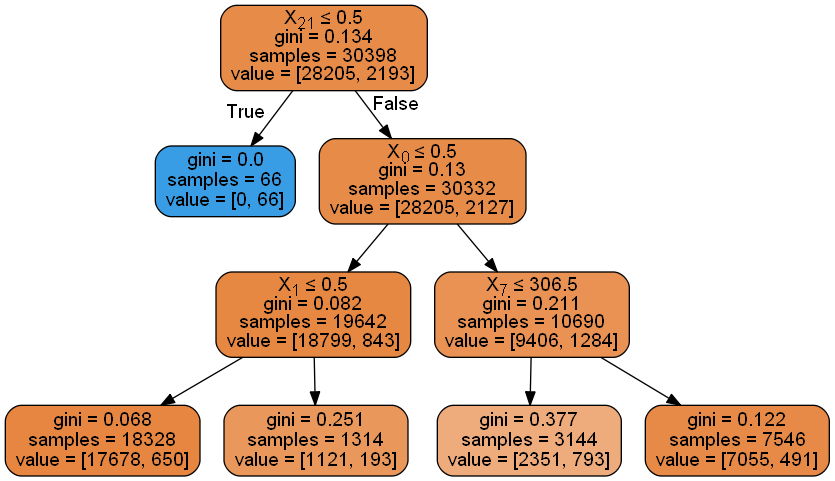

In [510]:
dot_data = StringIO()
export_graphviz(modelDecTree, out_file=dot_data, 
 filled=True, rounded=True,
 special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
Image(graph.create_png())

In [511]:
Ypred=modelDecTree.predict(Xtest)
print("Accuracy:",metrics.accuracy_score(Ytest, Ypred))
print("Precision",metrics.precision_score(Ytest, Ypred))
print("Recall",metrics.recall_score(Ytest, Ypred))
print("f1_score",metrics.f1_score(Ytest, Ypred))

Accuracy: 0.9303807184525638
Precision 1.0
Recall 0.03407880724174654
f1_score 0.06591143151390319


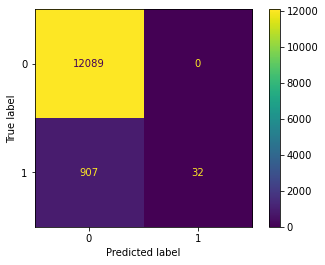

In [517]:
metrics.plot_confusion_matrix(modelDecTree,Xtest,Ytest)

# Random Forest

In [596]:
modelRandForest=RandomForestClassifier(random_state=5)

In [604]:
np.random.seed(32)
print(modelRandForest.get_params().keys()) #To know all the parameters of the randomForest
hyp_params={'max_depth':[2,3,4,5],
           "bootstrap":[True, False],#Whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree.
           "max_features":['auto','sqrt','log2',None],
           'criterion': ['gini', 'entropy']}
gridSearchCV=GridSearchCV(modelRandForest,cv = 10,   #Determines the cross-validation splitting strategy.default is 5
                     param_grid=hyp_params,n_jobs=-1)
gridSearchCV.fit(Xtrain,Ytrain.values.ravel())
print('Best Parameters using grid search: \n', gridSearchCV.best_params_)

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])
Best Parameters using grid search: 
 {'bootstrap': True, 'criterion': 'gini', 'max_depth': 2, 'max_features': None}


In [597]:
modelRandForest.set_params(criterion='gini',max_depth=2,max_features=None,bootstrap=True)

RandomForestClassifier(max_depth=2, max_features=None, random_state=5)

In [598]:
modelRandForest.fit(Xtrain,ytrain.values.ravel())

RandomForestClassifier(max_depth=2, max_features=None, random_state=5)

In [599]:
modelRandForest.score(Xtest,Ytest)

0.9303807184525638

In [590]:
modelRandForest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 2,
 'max_features': None,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 5,
 'verbose': 0,
 'warm_start': False}

In [591]:
modelRandForest.set_params(warm_start=True, 
                  oob_score=True)
min_estimators = 101
max_estimators = 500

error_rate = {}
for i in range(min_estimators, max_estimators + 1):
#     print(f'working for{i}')
    modelRandForest.set_params(n_estimators=i)
    modelRandForest.fit(Xtrain, Ytrain.values.ravel())

    oob_error = 1 - modelRandForest.oob_score_
    error_rate[i] = oob_error

In [592]:
oob_series = pd.Series(error_rate)

Text(0.5, 1.0, 'OOB Error Rate Across various Forest sizes \n(From 101 to 500 trees)')

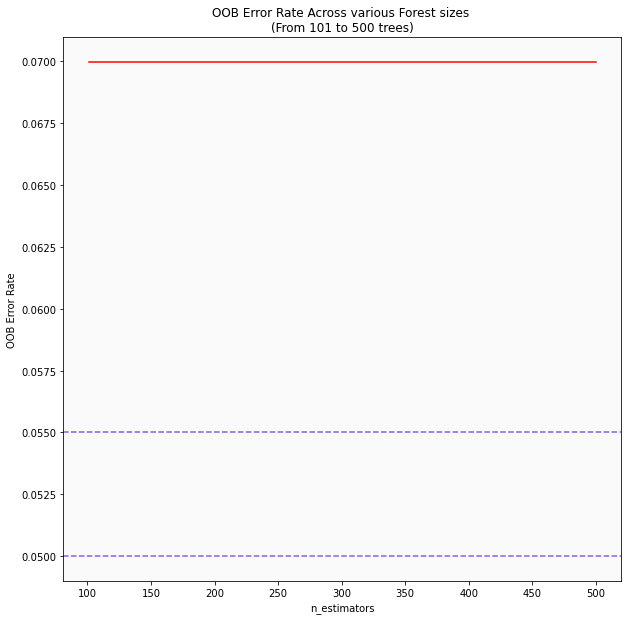

In [593]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.set_facecolor('#fafafa')

oob_series.plot(kind='line',color = 'red')
plt.axhline(0.055, color='#875FDB',linestyle='--')
plt.axhline(0.05, color='#875FDB',linestyle='--')
plt.xlabel('n_estimators')
plt.ylabel('OOB Error Rate')
plt.title('OOB Error Rate Across various Forest sizes \n(From 101 to 500 trees)')

In [600]:
modelRandForest=RandomForestClassifier(random_state=5) #since oob error is same going with initial n_estimator
modelRandForest.set_params(criterion='gini',max_depth=2,max_features=None,bootstrap=True)
modelRandForest.fit(Xtrain,ytrain.values.ravel())
modelRandForest.score(Xtest,Ytest)

0.9303807184525638

In [607]:
Ypred1=modelRandForest.predict(Xtest)
print("Accuracy:",metrics.accuracy_score(Ytest, Ypred1))
print("Precision",metrics.precision_score(Ytest, Ypred1))
print("Recall",metrics.recall_score(Ytest, Ypred1))
print("f1_score",metrics.f1_score(Ytest, Ypred1))

Accuracy: 0.9303807184525638
Precision 1.0
Recall 0.03407880724174654
f1_score 0.06591143151390319


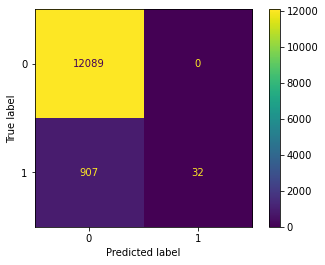

In [603]:
metrics.plot_confusion_matrix(modelRandForest,Xtest,Ytest)